**Autor:** Ricardo Hurtado                  

**Materia:** Procesamiento de Datos
                            
**Topico:** Introduccion a PySpark en el Ambiente Colab

**Contenido:** Limpieza y  Analisis de Datos sobre personas que han sufriendo de un accidente cerebrovascular

# Extraccion de Datos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SQLContext

In [2]:
# Se crea una SparkSession
spark = SparkSession.builder \
    .appName("SparkEnvironment") \
    .getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
Stroke_File_path = "/content/drive/MyDrive/Colab Notebooks/EXTRA/Prosesamiento datos Datasets/stroke_pyspark.csv"

# Crea un DataFrame de Spark a partir del archivo CSV
df00 = spark.read.csv(Stroke_File_path, header=True, inferSchema=True)

# Muestra las primeras filas del DataFrame
df00.show(5)


Mounted at /content/drive
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|          

In [4]:
df00.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

###  Que Datos Contiene el Datafame

`id`: un número único para identificar a cada persona.

`gender`: género de la persona (`Male`, `Female`, `Other`).

`age`: edad en años.

`hypertension`: si tiene presión alta (0 = No, 1 = Sí).

`heart_disease`: si tiene alguna enfermedad del corazón (0 = No, 1 = Sí).

`ever_married`: si alguna vez se ha casado (`Yes` o `No`).

`work_type`: a qué se dedica (`Private`, `Self-employed`, `Govt_job`, `children`, etc.).

`Residence_type`: si vive en zona urbana o rural.

`avg_glucose_level`: nivel promedio de glucosa en sangre.

`bmi`: índice de masa corporal (relación entre peso y estatura).

`smoking_status`: si fuma o ha fumado (`smokes`, `never smoked`, `formerly smoked`, etc.).

`stroke`: si ha tenido un ACV (accidente cerebrovascular) (0 = No, 1 = Sí).


In [5]:
df00.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



como se puede observar, hay datos numericos son del tipo string

In [6]:
#Se cambian los datos "age" y "bmi" de string a Int y Double
df01 = df00.withColumn("age", df00.age.cast("int"))
df01 = df00.withColumn("bmi", df00.bmi.cast("double"))
df01.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [7]:
#Cuantas entradas hay por Genero
df01.groupBy('gender').count().show()


+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



In [8]:
# se elimina 'other' de la columna gender al ser solo un dato

# Eliminar filas donde 'gender' es 'Other'
df01 = df01.filter(df01.gender != 'Other')

# Mostrar el recuento de entradas por género después de eliminar 'Other'
df01.groupBy('gender').count().show()


+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+





# REVISION DE DATOS NULOS Y LIMPIEZA

In [9]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



se encuentra que solo hay datos Nulos en la columba BMI por lo que se remplazara el valor nulo por el su BMI promedio por peso y rango de edades

In [10]:
# se recolectan los Promedios de el imc

rangos = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90)]



def calcular_promedio_imc(df, gender, rangos):
    promedios = {}
    for start, end in rangos:
        key = f'avg{end}{gender[0]}'

        avg = df.filter((col('gender') == gender) & (col('age') >= start) & (col('age') < end)) \
                .agg(F.mean(col('bmi'))).collect()[0][0]

        promedios[key] = avg

    return promedios

# Calcular los promedios para mujeres y hombres
resultadosF = calcular_promedio_imc(df01, 'Female', rangos)
print(resultadosF)

resultadosM = calcular_promedio_imc(df01, 'Male', rangos)
print(resultadosM)

{'avg10F': 18.687962962962963, 'avg20F': 25.202371541501993, 'avg30F': 28.110054347826086, 'avg40F': 31.114250614250615, 'avg50F': 31.147260273972595, 'avg60F': 31.64794816414686, 'avg70F': 30.777976190476185, 'avg80F': 29.53778501628664, 'avg90F': 28.23577981651375}
{'avg10M': 19.03168724279836, 'avg20M': 24.584051724137947, 'avg30M': 28.228823529411773, 'avg40M': 31.372321428571432, 'avg50M': 31.936329588014974, 'avg60M': 31.889181286549697, 'avg70M': 31.3031496062992, 'avg80M': 29.140291262135918, 'avg90M': 28.34931506849315}


In [11]:
#remplazar NULL por promedios por su rango de edad

promedios = {**resultadosF, **resultadosM}

def remplazar_nulls(df, promedios, rangos):
    for start, end in rangos:
        for gender in ['Female', 'Male']:
            key = f'avg{end}{gender[0]}'
            avg_bmi = promedios.get(key, None)

            # Asegurarse de que el promedio no sea None
            if avg_bmi is not None:
                # Reemplazar los valores NULL de BMI con el promedio calculado para ese grupo
                df = df.withColumn(
                    'bmi',
                    F.when(
                        (F.col('gender') == gender) &
                        (F.col('age') >= start) & (F.col('age') < end) &
                        F.col('bmi').isNull(), avg_bmi
                    ).otherwise(F.col('bmi'))
                )
    return df


df02 = remplazar_nulls(df01, promedios, rangos)

In [12]:
#Se visualiza si aun existen datos nulos
df02.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df02.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



# Visualizacion e Analisis de datos

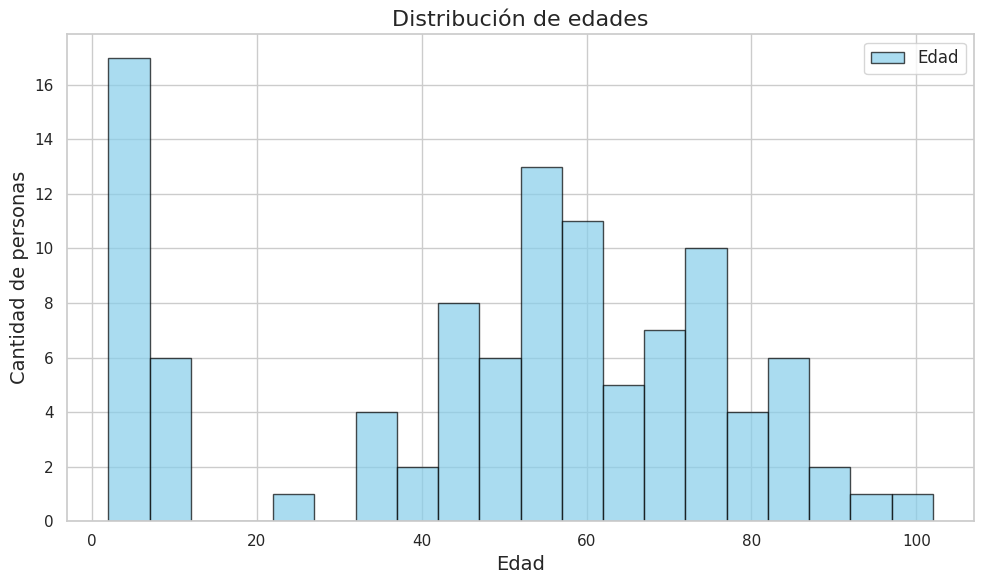

In [13]:
#Grafico de Distribucion por Edades

sns.set(style="whitegrid")

clases, cantidad = df02.groupby('age').count().select('count').rdd.flatMap(lambda x: x).histogram(20)
plt.figure(figsize=(10, 6))
plt.hist(clases[:-1], bins=clases, weights=cantidad, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de edades', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Cantidad de personas', fontsize=14)
plt.legend(['Edad'], loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

Hay una cantida alta de personas muy jovenes entre los datos con edades menores a los 10 años aproximadamente

apartir de los 20 años las edades parecen asemejarse a una distribucion normal

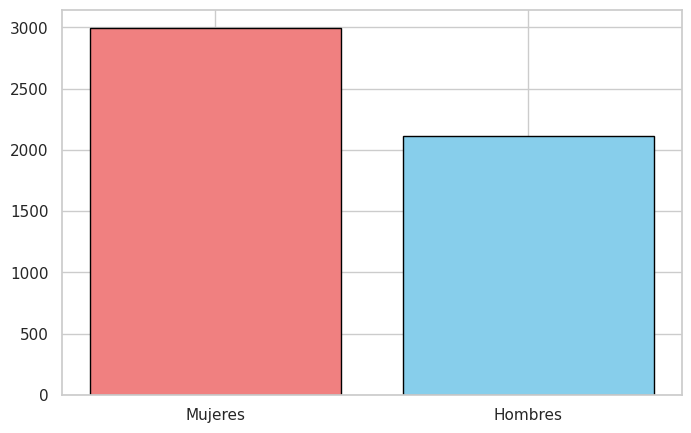

In [14]:
## Conteo por genero

sns.set(style="whitegrid")
genero = df02.groupby('gender').count().select('count').rdd.flatMap(lambda x: x).collect()

categoria = ['Mujeres', 'Hombres']

plt.figure(figsize=(8, 5))
grafica = plt.bar(categoria, genero, color=['lightcoral', 'skyblue'], edgecolor='black')

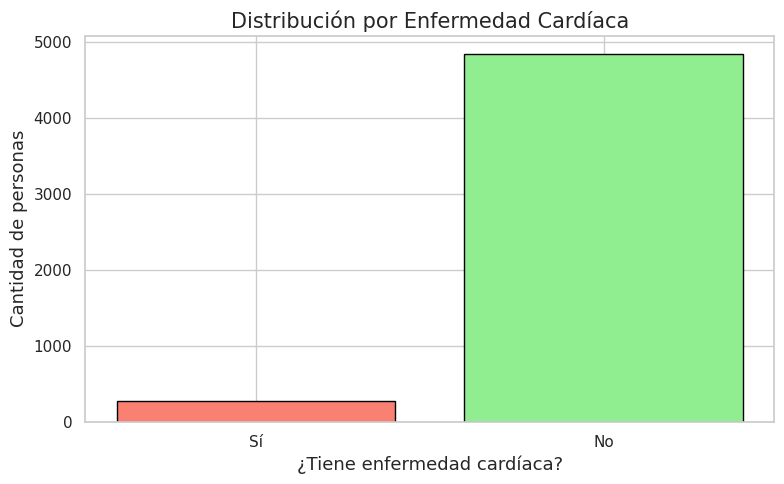

In [15]:
## Cantidad de personas con enfermedades cardiacas

sns.set(style="whitegrid")

enfCardiaca = df02.groupby('heart_disease').count().select('count').rdd.flatMap(lambda x: x).collect()
categorias = ['Sí', 'No']

plt.figure(figsize=(8, 5))
grafica = plt.bar(categorias, enfCardiaca, color=['salmon', 'lightgreen'], edgecolor='black')

plt.ylabel('Cantidad de personas', fontsize=13)
plt.xlabel('¿Tiene enfermedad cardíaca?', fontsize=13)
plt.title('Distribución por Enfermedad Cardíaca', fontsize=15)

plt.tight_layout()
plt.show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4860|
+------+-----+



<ipython-input-16-a195f64e28cf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stroke_categories, y=stroke_values, palette='pastel', edgecolor='black')


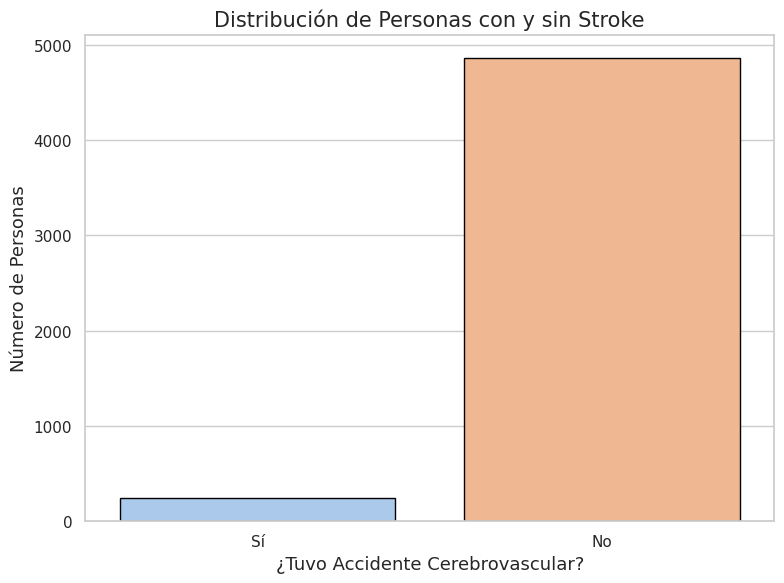

In [16]:
# grafica de si la persona ha tenido un accidente cardiovascular

sns.set(style="whitegrid")

df02.groupBy('stroke').count().show()
stroke_counts = df02.groupBy('stroke').count().collect()

stroke_categories = ['No', 'Sí'] if stroke_counts[0]['stroke'] == 0 else ['Sí', 'No']
stroke_values = [row['count'] for row in stroke_counts]

plt.figure(figsize=(8, 6))
sns.barplot(x=stroke_categories, y=stroke_values, palette='pastel', edgecolor='black')
plt.xlabel('¿Tuvo Accidente Cerebrovascular?', fontsize=13)
plt.ylabel('Número de Personas', fontsize=13)
plt.title('Distribución de Personas con y sin Stroke', fontsize=15)

plt.tight_layout()
plt.show()



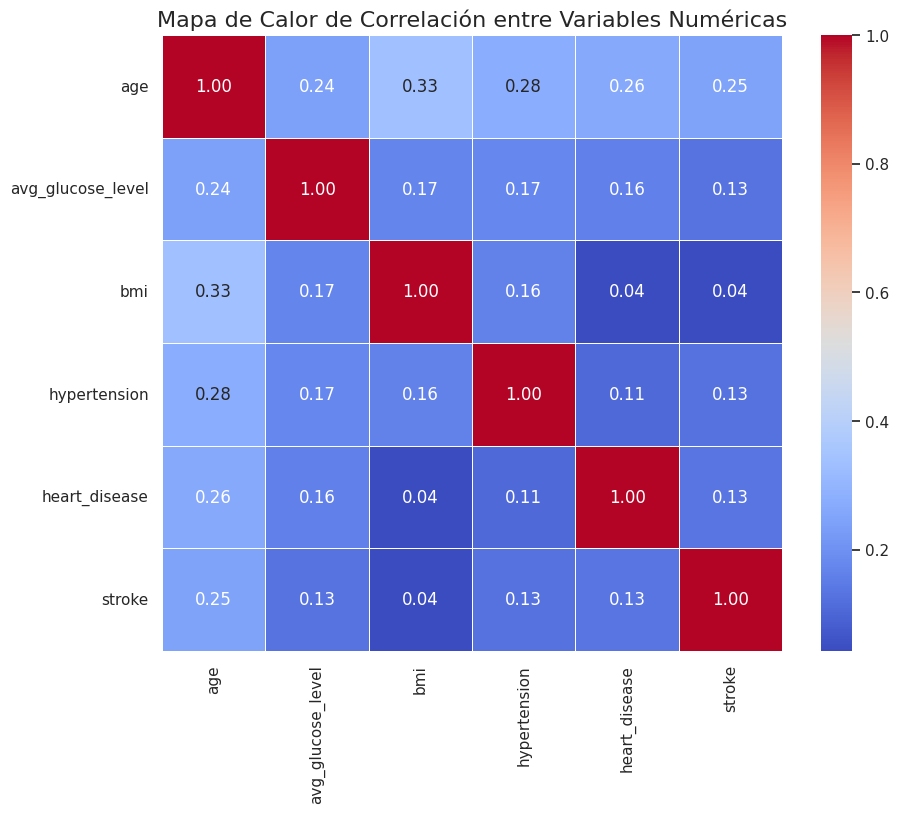

In [17]:
import matplotlib.pyplot as plt
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
pandas_df = df02.select(numerical_cols).toPandas()
corr_matrix = pandas_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlación entre Variables Numéricas', fontsize=16)
plt.show()

#Machine Learning y Evaluacion de Metricas

In [18]:
df02.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

categoricalCols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numericCols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Indexar y codificar las variables categóricas
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") for col in categoricalCols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in categoricalCols]

# Ensamblar características
assemblerInputs = numericCols + [col + "_Vec" for col in categoricalCols]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

#  Modelo de regresión logística
Modelolr = LogisticRegression(featuresCol='features', labelCol='stroke', maxIter=10)

#  Pipeline completo
pipeline = Pipeline(stages=indexers + encoders + [assembler, Modelolr])

#  División de los datos (80% entrenamiento, 20% prueba)
train_data, test_data = df02.randomSplit([0.8, 0.2], seed=42)

#  Entrenamiento del modelo
modelo_entrenado = pipeline.fit(train_data)

#  Predicciones
results_ModeloA = modelo_entrenado.transform(test_data)
results_ModeloA.select("stroke", "prediction", "probability").show(10)

+------+----------+--------------------+
|stroke|prediction|         probability|
+------+----------+--------------------+
|     0|       0.0|[0.96936819850976...|
|     0|       0.0|[0.99645781084863...|
|     0|       0.0|[0.99393406028336...|
|     0|       0.0|[0.98727220031075...|
|     0|       0.0|[0.76097305944069...|
|     0|       0.0|[0.98661666885303...|
|     0|       0.0|[0.88425359434421...|
|     1|       0.0|[0.93496693460073...|
|     0|       0.0|[0.99825108913715...|
|     0|       0.0|[0.86254201718851...|
+------+----------+--------------------+
only showing top 10 rows



#Evaluacion de Metricas

Se crea la matriz de confusion para realizar un analisis del rendimiento del modelo

In [20]:
# porcentajes de 0 y 1 en columna prediction de resultados del ModeloA
prediction_counts = results_ModeloA.groupBy('prediction').count()
total_predictions = results_ModeloA.count()

prediction_percentages = prediction_counts.withColumn(
    "percentage", col("count") / total_predictions * 100
)

# Muestra el resultado
prediction_percentages.show()


+----------+-----+-------------------+
|prediction|count|         percentage|
+----------+-----+-------------------+
|       0.0|  986|  99.89868287740629|
|       1.0|    1|0.10131712259371835|
+----------+-----+-------------------+



In [21]:
stroke_counts = df02.groupBy('stroke').count()
total_rows = df02.count()
stroke_percentage = stroke_counts.withColumn("percentage", col("count") / total_rows * 100)

# Muestra el resultado
stroke_percentage.show()

+------+-----+-----------------+
|stroke|count|       percentage|
+------+-----+-----------------+
|     1|  249|4.873752201996477|
|     0| 4860|95.12624779800353|
+------+-----+-----------------+



In [22]:
# Calcular la matriz de confusión en PySpark
from pyspark.sql.functions import col

confusion_df = results_ModeloA.groupBy("stroke", "prediction").count().orderBy("stroke", "prediction")
confusion_df.show()

+------+----------+-----+
|stroke|prediction|count|
+------+----------+-----+
|     0|       0.0|  933|
|     1|       0.0|   53|
|     1|       1.0|    1|
+------+----------+-----+



Se analiza en la matriz de confuison un problema grave del modelo, solo tenemos estas metricas:

TN: 965 \
FN: 57
f

El modelo esta prediciendo todas las observaciones como 0 (no hay stroke). esto es peligroso dado el contexto, pues no detecta ningún caso positivo, lo cual puede pasar al tener una pequeña cantidad de datos.

Se procede a corroborar el modelo usando la metrica ROC





In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calcular el AUC
auc_roc = evaluator.evaluate(results_ModeloA)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.823945059743563


In [27]:
modelo_entrenado = modelo_entrenado.stages[-1]

# Obtener valores de ROC
roc = modelo_entrenado.summary.roc
roc.show(10)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|5.092946269416857E-4|0.010256410256410256|
|0.001273236567354...|0.015384615384615385|
|0.002037178507766743|0.020512820512820513|
|0.002801120448179...| 0.02564102564102564|
|  0.0035650623885918| 0.03076923076923077|
|0.004074357015533486|0.041025641025641026|
|0.004329004329004329| 0.05641025641025641|
|0.004583651642475172| 0.07179487179487179|
|  0.0053475935828877| 0.07692307692307693|
+--------------------+--------------------+
only showing top 10 rows



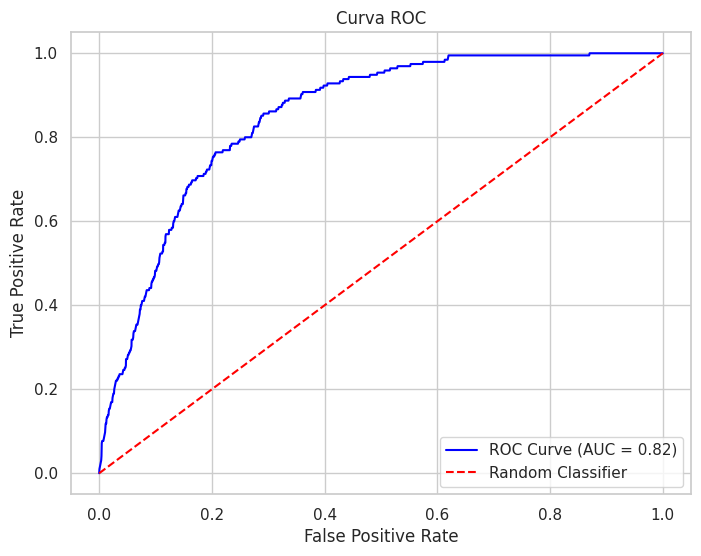

In [29]:
import matplotlib.pyplot as plt
roc_pd = roc.toPandas()

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(roc_pd['FPR'], roc_pd['TPR'], color='blue', label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

El modelo tiene un AUC de 0.82, lo que indica un buen desempeño para clasificar correctamente entre pacientes que han tenido un stroke y los que no. el AUC cercano a 1.0 Indica un buen rendimiento del modelo y su capacidad para aprender y predecir los datos correctamente. esto se refleja en la curva la cual al estar alejada de la linea roja indica que el modelo realmente aprendio a determinar patrones reales y no es aleatorio.


In [28]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")

# Imprimir métricas
print("Accuracy: ", evaluator_acc.evaluate(results_ModeloA))
print("Precision: ", evaluator_precision.evaluate(results_ModeloA))
print("Recall: ", evaluator_recall.evaluate(results_ModeloA))
print("F1 Score: ", evaluator_f1.evaluate(results_ModeloA))


Accuracy:  0.9463019250253293
Precision:  0.9491883327065235
Recall:  0.9463019250253293
F1 Score:  0.9211707476938703


El modelo acierta en el 94.6% de los casos. lo cual es un nivel de acierto Muy alto el cual indica que el modelo logro predecir con exito casi el 95% de los datos. tambien tuvo una alta precision con un valor de 94.9% lo cual indica que la mayoria de los valores fueron similares siedno que se predijo correctamente que la mayoria no sufrionun Stroke. De todos los pacientes que sí tuvieron un stroke, el modelo detectó al 94.6% dado por el valor Recall. para este caso  recall (94.6%) y F1 Score (92.1%) respaldan que el modelo no solo es preciso, sino también confiable tanto en la detección como en la predicción de falsos positivos y negativos.

sin embargo puesto que la gran mayoria de datos los casos de stroke son muy pocos. el modelo podria sufrir un sesgo puesto que al haber una myoria clara en los datos el modelo aprenderia a intentar evaluar siedno que la probabilidad de que el valor stroke fuera 0, seria mucho mayor.


